# NLP project

#### Dataset
Amazon reviews dataset


#### We will use the following columns:

review_body

stars

language

product_category

#### Work plan
1. Only work with one category
2. Remove reviews with 3 star ratings
3. Tokenize and Word2Vec 
4. CNN
    https://towardsdatascience.com/nlp-with-cnns-a6aa743bdc1e
    https://towardsdatascience.com/nlp-with-cnns-a6aa743bdc1e
5. LSTM
    https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/


https://towardsdatascience.com/multilingual-amazon-reviews-classification-f55f8a650c9a

#### Mode detailed ideas
1. Tokenize
2. OneHot encoder
    2.1 Data array of arrays

    2.2 OneHot representation of each word put together for each sentence

3. Embeddings? Word2Vec?
    3.1 Data array of arrays

    3.2 Word2Vec representation of each word put together for each sentence
    
4. Add padding?
5. CNN for important features? Understands internal structure of data but not for long dependencies
6. Apply LSTM for long term dependencies?
7. LSTM --> classification layer
8. Apply to target language with small corpora


One-hot vectors are high-dimensional and sparse, while word embeddings are low-dimensional and dense 
(they are usually between 50–600 dimensional). When you use one-hot vectors as a feature in a classifier, 
your feature vector grows with the vocabulary size; word embeddings are more computationally efficient.



### Imports

In [87]:
import numpy as np
import pandas as pd
import torch 

import regex as re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import itertools

import gensim
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\test\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\test\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [88]:
# import our script
%run -i cnn.ipynb
%run -i lstm.ipynb
%run -i cnn_test.ipynb

In [89]:
cnn = CNN(1,1,3,1)

### Loading in the data

In [90]:
from datasets import list_datasets, load_dataset, list_metrics, load_metric
import datasets
dataset  = datasets.load_dataset('amazon_reviews_multi')

No config specified, defaulting to: amazon_reviews_multi/all_languages
Reusing dataset amazon_reviews_multi (C:\Users\test\.cache\huggingface\datasets\amazon_reviews_multi\all_languages\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)
100%|██████████| 3/3 [00:00<00:00,  7.98it/s]


In [91]:
train = dataset["train"]
data = pd.DataFrame(train)

In [138]:
test= dataset["test"]
test=pd.DataFrame(test)

In [92]:
data.shape

(1200000, 8)

### Changing the stars to positive or negative sentiment

In [93]:
sentiment = {4:1, 5:1, 1:0, 2:0}

import numpy as np
data['sentiment']=data.stars.replace(sentiment)

In [139]:
test['sentiment']=test.stars.replace(sentiment)

### Filtering out the individual languages + deleting reviews with 3 stars

In [94]:
english_data = data.loc[(data['language']=='en') & (data['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]
german_data = data.loc[(data['language']=='de') & (data['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]
fr_data = data.loc[(data['language']=='fr') & (data['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]
ja_data = data.loc[(data['language']=='ja') & (data['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]
zh_data = data.loc[(data['language']=='zh') & (data['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]
ch_data = data.loc[(data['language']=='ch') & (data['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]

In [142]:
english_test = test.loc[(test['language']=='en') & (test['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]
german_test = test.loc[(test['language']=='de') & (test['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]
fr_test = test.loc[(test['language']=='fr') & (test['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]
ja_test = test.loc[(test['language']=='ja') & (test['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]
zh_test = test.loc[(test['language']=='zh') & (test['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]
ch_test = test.loc[(test['language']=='ch') & (test['stars']!= 3),['review_body', 'language','sentiment', 'product_category']]

### Filtering out the home category

In [95]:
en_df = english_data.loc[(english_data['product_category']=='home'), ['review_body', 'language','sentiment', 'product_category']]
ge_df = german_data.loc[(german_data['product_category']=='home'),['review_body', 'language','sentiment', 'product_category']]


In [143]:
en_test= english_test.loc[(english_test['product_category']=='home'), ['review_body', 'language','sentiment', 'product_category']]
ge_test = german_test.loc[(german_test['product_category']=='home'),['review_body', 'language','sentiment', 'product_category']]


### Tokenization


#### Removing stopwords and tokenizing the 'review_body' column

In [96]:
stop = set(stopwords.words('english'))
 
en_df["reviews_without_stop"] = en_df['review_body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [144]:
stop = set(stopwords.words('english'))
 
en_test["reviews_without_stop"] = en_test['review_body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [166]:
en_test.shape

(351, 5)

In [97]:
shuf_en_df=en_df.sample(frac=1)
shuf_array=shuf_en_df['reviews_without_stop'].to_numpy()
array=shuf_array[:7000]

#array = en_df['reviews_without_stop'].to_numpy()
#array = array[:1000]

In [167]:
shuf_en_test=en_test.sample(frac=1)
shuf_test_array=shuf_en_test['reviews_without_stop'].to_numpy()
test_array=shuf_test_array

In [168]:
def generate_token(array):
    '''Input: A 1D numpy array of strings. One element is one "tweet"
    Output: Splitted words, one output line per input line, with spaces between tokens.
    Returns "a list of lists" where each token is a string in the list'''
    token_list = []

    # Regular Expression to seperate tokens
    # Our tokens:
    # words and hashtags |   a symbol suffixing a word | emojis | @user
    #r_html = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)" # broken :(
    r_words_and_hashtags = r"[#a-zA-Z0-9_\-\—\'\;\:\&\\]+"
    r_emojies = r"[\U00010000-\U0010ffff]"
    r_user = r"\@user"
    r_punctuation_types = r"[\!\#\$\%\(\)\*\+\,\-\.\/\<\=\>\?\@\[\]\^\_\`\{\|\}\~]{1}"

    # Final regex
    regex = r_words_and_hashtags + "|" + r_emojies  + "|" + r_user + "|" + r_punctuation_types 
    #print(regex)

    # Dictionary with charecters and their better replacements
    replace_dict = {
        "`" : "'",
        "’" : "'",
        "´" : "'",
        r"\n" : " "
    }

    for i, review in enumerate(array):
        
        # Unescape special HTML charecters
       # review = unescape(review)

        # Loop through and replace problematic charecters with better solutions
        for char_to_replc in replace_dict.keys():
            review = review.replace(char_to_replc, replace_dict[char_to_replc])    

        # Lowercase to reduce the number of unique tokens
        review = review.lower()
        tokens = re.findall(regex, review)

        # Store string in np array
        token_list.append(tokens)
    return token_list



tokens = generate_token(array)
test_tokens = generate_token(test_array)

In [169]:
test_array.shape

(351,)

### Creating embeddings

Downloading vectors from fasttext https://fasttext.cc/docs/en/aligned-vectors.html

In [170]:
# Longest review is 382 words/sentences
print(len(max(tokens, key=len)))

# Finding how many sentences are over 128 words
long_sen = []
for sen in tokens:
    if len(sen)>128:
        long_sen.append(len(sen))

# printing the number of sentences over 128 words
print(len(long_sen))

291
32


In [171]:
# Longest test review is 166 words/sentences
print(len(max(test_tokens, key=len)))

#because we are about to do testing, we will not truncate data, but instead pad all of it to its max length


166


In [172]:
#make a list containing all lengths ow shortened sentences
len_sentences = []
for sen in tokens:
    len_sentences.append(len(sen))

#len_sentences
# len_sentences = [len(sen) for sen in tokens]

In [173]:
#make a list containing all lengths of sentences in the test data
len_sentences = []
for sen in test_tokens:
    len_sentences.append(len(sen))

#len_sentences
# len_sentences = [len(sen) for sen in tokens]

In [101]:
#padded_tokens = pad_GloVe(tokens,128)

In [174]:
# tokens = fasttext.tokenize(data)
en_model = gensim.models.KeyedVectors.load_word2vec_format("wiki.en.align.vec", limit=10000)
de_model = gensim.models.KeyedVectors.load_word2vec_format("wiki.de.align.vec", limit=10000)

In [103]:
en_df

,review_body,language,sentiment,product_category,reviews_without_stop
200002,I received my first order of this product and ...,en,0,home,I received first order product broke I ordered...
200006,Ordered 2 they shipped 1 promised by certain d...,en,0,home,"Ordered 2 shipped 1 promised certain day, next..."
200018,Stems were broken due to poor packing. Shapes ...,en,0,home,Stems broken due poor packing. Shapes way diff...
200040,The wicker baskets all unravel. Cheaply made. ...,en,0,home,The wicker baskets unravel. Cheaply made. I re...
200067,"The first time is very good, very handy, but m...",en,0,home,"The first time good, handy, two times water, n..."
...,...,...,...,...,...
399975,I wanted a rose flower cotton quilt to overlay...,en,1,home,I wanted rose flower cotton quilt overlay comf...
399981,"Nice, thick wrapping paper. It has a nice velv...",en,1,home,"Nice, thick wrapping paper. It nice velvet/mat..."
399989,The colors are bright and fits the bed nice,en,1,home,The colors bright fits bed nice
399991,Love this! Put this on the wall above my bed a...,en,1,home,Love this! Put wall bed looks awesome!


In [175]:
en_test

,review_body,language,sentiment,product_category,reviews_without_stop
5015,I did not receive this item.,en,0,home,I receive item.
5026,The clear backing lacks the stickiness to keep...,en,0,home,The clear backing lacks stickiness keep letter...
5030,"Very disappointed in the quality, patterns and...",en,0,home,"Very disappointed quality, patterns size I don..."
5034,Added so much to the projects! Works well.,en,0,home,Added much projects! Works well.
5037,The item u sent me was not what I ordered no s...,en,0,home,The item u sent I ordered stars
...,...,...,...,...,...
9951,I finally had time to sit down and read the in...,en,1,home,I finally time sit read instructions. It simpl...
9953,"Quick shipping, Quality product, Perfect fit",en,1,home,"Quick shipping, Quality product, Perfect fit"
9972,Love the look of these! They look like real ti...,en,1,home,Love look these! They look like real tiles! Th...
9993,"Works very well. Easy to set alarms, and time....",en,1,home,"Works well. Easy set alarms, time. The snooze/..."


In [160]:
#NY padder

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=str)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


padded_tokens = padding_(tokens, 128)
#x_test_pad = padding_(x_test, 128)

In [176]:
#NY test padder

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=str)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


padded_test_tokens = padding_(test_tokens, len(max(test_tokens, key=len)))

#x_test_pad = padding_(x_test, 128)

In [177]:
padded_tokens.shape
padded_test_tokens.shape


(351, 166)

In [106]:
# Creating embeddings with padding
emb_en=[]
for sentence in padded_tokens:
    for word in sentence:
        if word in en_model:
            emb = en_model[word]
        else:
            emb = np.zeros(300)
        emb_en.append(emb)

In [107]:
# Creating embeddings with padding
emb_en=[]
for sentence in padded_tokens:
    sent = []
    for word in sentence:
        if word in en_model:
            emb = en_model[word]
        else:
            emb = np.zeros(300)
        sent.append(emb)
    emb_en.append(sent)

In [178]:
# Creating embeddings for test data with padding
test_emb_en=[]
for sentence in padded_test_tokens:
    sent = []
    for word in sentence:
        if word in en_model:
            emb = en_model[word]
        else:
            emb = np.zeros(300)
        sent.append(emb)
    test_emb_en.append(sent)

In [108]:
# Adding batch dimension (from Rob)
# https://github.itu.dk/robv/2ndyearproject-2022-material/blob/main/assignments/week5/week5.ipynb

In [109]:
# Adding a batch dimension of 1
# TO DO: Add batch size of 32 instead of 1
torch_emb = torch.Tensor(emb_en)
target = shuf_en_df['sentiment'].to_numpy()[:7000]
# target = en_df['sentiment']
#torch_emb = torch_emb[None, :]

# import pickle
# with open('emb.pkl', 'wb') as f:
#     pickle.dump(torch_emb, f)
# with open('target.pkl', 'wb') as f:
#     pickle.dump(target, f)

ValueError: I/O operation on closed file.

In [180]:
test_torch_emb = torch.Tensor(test_emb_en)
test_target = shuf_en_test['sentiment'].to_numpy()[:7000]

In [179]:
# Running cnn_test
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(CNN, self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        self.p1 = nn.MaxPool2d(kernel_size)
    
    def forward(self, x):
        out = self.c1(x)
        out = self.p1(out)
        return out

In [184]:
cnn = CNN(1, 1, 3, 1)
# cnn = CNN(1,1,(10,5),1)
cnn_out = cnn(torch_emb.reshape(-1, 1, 128, 300))


RuntimeError: [enforce fail at C:\Users\builder\tkoch\workspace\pytorch\pytorch_1647970138273\work\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 8410752000 bytes.

In [183]:
cnn = CNN(1, 1, 3, 1)
# cnn = CNN(1,1,(10,5),1)
cnn_out_test = cnn(test_torch_emb.reshape(-1, 1, 351, 300))

In [112]:
cnn_out

tensor([[[[-0.3057, -0.3057, -0.3057,  ..., -0.3057, -0.3057, -0.3057],
          [-0.3057, -0.3057, -0.3057,  ..., -0.3057, -0.3057, -0.3057],
          [-0.3057, -0.3057, -0.3057,  ..., -0.3057, -0.3057, -0.3057],
          ...,
          [-0.2347, -0.2768, -0.2459,  ..., -0.2414, -0.2542, -0.1907],
          [-0.2472, -0.2366, -0.2107,  ..., -0.2659, -0.2137, -0.1896],
          [-0.2740, -0.2367, -0.2566,  ..., -0.2828, -0.2290, -0.1891]]],


        [[[-0.3057, -0.3057, -0.3057,  ..., -0.3057, -0.3057, -0.3057],
          [-0.3057, -0.3057, -0.3057,  ..., -0.3057, -0.3057, -0.3057],
          [-0.3057, -0.3057, -0.3057,  ..., -0.3057, -0.3057, -0.3057],
          ...,
          [-0.2326, -0.2626, -0.2245,  ..., -0.2506, -0.2535, -0.1918],
          [-0.2475, -0.2416, -0.2060,  ..., -0.2251, -0.2557, -0.2230],
          [-0.2359, -0.2527, -0.2337,  ..., -0.2452, -0.2436, -0.2024]]],


        [[[-0.3057, -0.3057, -0.3057,  ..., -0.3057, -0.3057, -0.3057],
          [-0.3057, -0.305

In [113]:
import torch.nn as nn

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [185]:
#Annas test lstm
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, no_layers=2, drop_prob=0.5):
        super(LSTM, self).__init__()

        self.input_size=input_size
        self.hidden_dim= hidden_dim
        self.output_size = output_size
        self.num_layers = no_layers
        
        
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers=no_layers,
                            batch_first=True, bidirectional=True)

    
        self.dropout= nn.Dropout(0.3)

        # linear and sigmoid layer
        self.linear = nn.Linear(self.hidden_dim*2, output_size)
        self.sig = nn.Sigmoid()
    
    

    def forward(self, x):
        # feed lstm input --> (N, L, H_dim*2)
        out, hidden = self.lstm(x)

        # select correct hidden state for many-to-one prediction --> (N, H_dim*2)
        # -----------------------------------------------------------------
        # IF DOING SIMPLE HIDDEN STATE HANDLING
        # select last element in sequence from all batches
        # out = out[:, -1]

        # IF DOING COMPLEX HIDDEN STATE HANDLING
        # select last element in sequence for each direction, see https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66
        out_forward = out[:, -1, :self.hidden_dim]
        out_backward = out[:, 0, self.hidden_dim:]
        out = torch.concat((out_forward, out_backward), axis=1)
        # -----------------------------------------------------------------

        # do dropout
        out = self.dropout(out)

        # final layer --> (N, out_dim)
        out = self.linear(out)

        # activation function on linear layer
        out = self.sig(out)

        return out, hidden

In [186]:
no_layers = 4
input_size = 300 #extra 1 for padding
output_size = 1
hidden_dim = 250

model = LSTM(input_size, hidden_dim, no_layers, drop_prob=0.5)

model.to(device)

batch_size = 120

'''
hidden = model.init_hidden(batch_size)



for i, (x_batch, y_batch) in enumerate(train_loader):
    print(x_batch.shape)

    print(model(x_batch, hidden)[0].shape)
    #assert len(x_batch) == len(y_batch)
    pred, hidden = model(x_batch, hidden)
    pred=y_batch.reshape(-1,1)
    print(pred)

    print(y_batch)
    loss = loss_fn(pred, y_batch)
    break

#model=LSTM(300, 100, 1)
#embs_lens = torch.tensor(len_sentences)
## model(torch_emb).shape
'''

'\nhidden = model.init_hidden(batch_size)\n\n\n\nfor i, (x_batch, y_batch) in enumerate(train_loader):\n    print(x_batch.shape)\n\n    print(model(x_batch, hidden)[0].shape)\n    #assert len(x_batch) == len(y_batch)\n    pred, hidden = model(x_batch, hidden)\n    pred=y_batch.reshape(-1,1)\n    print(pred)\n\n    print(y_batch)\n    loss = loss_fn(pred, y_batch)\n    break\n\n#model=LSTM(300, 100, 1)\n#embs_lens = torch.tensor(len_sentences)\n## model(torch_emb).shape\n'

In [187]:
target = shuf_en_df['sentiment'].to_numpy()[:7000]
target = torch.from_numpy(target).float().reshape(-1,1)

In [188]:
test_target = shuf_en_test['sentiment'].to_numpy()
test_target = torch.from_numpy(test_target).float().reshape(-1,1)

In [190]:
torch_emb.shape
target.shape
test_target.shape


torch.Size([351, 1])

In [191]:
from torch.utils.data import TensorDataset, DataLoader
td = TensorDataset(torch_emb, target)

In [192]:
test_td = TensorDataset(test_torch_emb, test_target)

In [120]:
target.shape

torch.Size([7000, 1])

In [122]:
class CNN2d_LSTM(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, input_size, hidden_dim, output_size, num_layers):
        super(CNN2d_LSTM, self).__init__()
        # self.c1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        self.c1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=kernel_size, stride=stride)
        self.c2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=stride)
        self.p1 = nn.MaxPool2d(kernel_size)
        self.relu = nn.ReLU()

        dummy_data = torch.zeros(1, 1, 100, input_size)
        self.lstm_input_size = self.p1(self.c2(self.c1(dummy_data))).shape[-1]

        self.in_channels = in_channels
        self.hidden_dim= hidden_dim
        self.output_size = output_size
        self.num_layers = num_layers
        
        
        self.lstm = nn.LSTM(self.lstm_input_size, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)

    
        self.dropout= nn.Dropout(0.3)

        # linear and sigmoid layer
        self.linear = nn.Linear(self.hidden_dim*2, output_size)
        self.sig = nn.Sigmoid()
    
    

    def forward(self, x):
        # prepare input for CNN, (N, L, H) --> (N, 1, L, H)
        out = x.reshape(x.shape[0], self.in_channels, x.shape[1], x.shape[2])
        out = self.c1(out)
        out = self.p1(out)

        out = out[:, 0]

        # feed lstm input --> (N, L, H_dim*2)
        out, hidden = self.lstm(out)

        # select correct hidden state for many-to-one prediction --> (N, H_dim*2)
        # -----------------------------------------------------------------
        # IF DOING SIMPLE HIDDEN STATE HANDLING
        # select last element in sequence from all batches
        # out = out[:, -1]

        # IF DOING COMPLEX HIDDEN STATE HANDLING
        # select last element in sequence for each direction, see https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66
        out_forward = out[:, -1, :self.hidden_dim]
        out_backward = out[:, 0, self.hidden_dim:]
        out = torch.concat((out_forward, out_backward), axis=1)
        # -----------------------------------------------------------------


        # do dropout
        out = self.dropout(out)

        # final layer --> (N, out_dim)
        out = self.linear(out)


        # activation function on linear layer
        out = self.sig(out)

        return out, hidden

In [ ]:
class CNN1d_LSTM(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, input_size, hidden_dim, output_size, num_layers):
        super(CNN2d_LSTM, self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride)
        self.p1 = nn.MaxPool2d(kernel_size)

        dummy_data = torch.zeros(1, 1, 100, input_size)
        self.lstm_input_size = self.p1(self.c1(dummy_data)).shape[-1]

        self.in_channels = in_channels
        self.hidden_dim= hidden_dim
        self.output_size = output_size
        self.num_layers = num_layers
        
        
        self.lstm = nn.LSTM(self.lstm_input_size, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)

    
        self.dropout= nn.Dropout(0.3)

        # linear and sigmoid layer
        self.linear = nn.Linear(self.hidden_dim*2, output_size)
        self.sig = nn.Sigmoid()
    
    

    def forward(self, x):
        # prepare input for CNN, (N, L, H) --> (N, 1, L, H)
        out = x.reshape(x.shape[0], self.in_channels, x.shape[1], x.shape[2])
        out = self.c1(out)
        out = self.p1(out)

        out = out[:, 0]

        # feed lstm input --> (N, L, H_dim*2)
        out, hidden = self.lstm(out)

        # select correct hidden state for many-to-one prediction --> (N, H_dim*2)
        # -----------------------------------------------------------------
        # IF DOING SIMPLE HIDDEN STATE HANDLING
        # select last element in sequence from all batches
        # out = out[:, -1]

        # IF DOING COMPLEX HIDDEN STATE HANDLING
        # select last element in sequence for each direction, see https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66
        out_forward = out[:, -1, :self.hidden_dim]
        out_backward = out[:, 0, self.hidden_dim:]
        out = torch.concat((out_forward, out_backward), axis=1)
        # -----------------------------------------------------------------


        # do dropout
        out = self.dropout(out)

        # final layer --> (N, out_dim)
        out = self.linear(out)


        # activation function on linear layer
        out = self.sig(out)

        return out, hidden

In [123]:
torch_emb.requires_grad

False

In [ ]:
#NY TRÆNING


# no_layers = 2
# input_size = 300 #extra 1 for padding
# output_size = 1
# hidden_dim = 100

#model = LSTM(input_size, hidden_dim, no_layers, drop_prob=0.5)

in_channels = 1
out_channels = 1
kernel_size = 3
stride = 1
input_size = 300
hidden_dim = 100
output_size = 1
num_layers = 2

# input shape: (N, in_channels, height=sequence_length, width=embedding_dim/input_size)
model = CNN_LSTM(in_channels, out_channels, kernel_size, stride, input_size, hidden_dim, output_size, num_layers)


model.to(device)

lr=3e-4

loss_fn = nn.BCELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
#def acc(pred,label):
    #pred = torch.round(pred.squeeze())
    #return torch.sum(pred == label.squeeze()).item()

valid_loss_min= np.Inf
clip=5
epochs = 50
batch_size=120


train_size = int(len(td)*0.8)
val_size = int(len(td) - train_size)
train_dataset, val_dataset = torch.utils.data.random_split(td, [train_size, val_size], generator=torch.Generator().manual_seed(100))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



model.train()
loss_hist = []
for epoch in range(epochs):
    print(epoch)
    batch_hist = []


    for i, (x_batch, y_batch) in enumerate(train_loader):

        #assert len(x_batch) == len(y_batch)
        # hidden = model.init_hidden(batch_size)
        pred, hidden = model(x_batch)

        
        loss = loss_fn(pred, y_batch).to(device)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_hist.append(loss.item())
    print(np.mean(batch_hist))
    loss_hist.append(np.mean(batch_hist))


NameError: name 'CNN_LSTM' is not defined

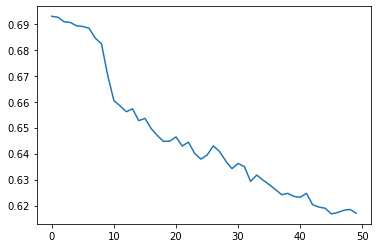

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(len(loss_hist)), loss_hist)

In [194]:
class LSTM_test(nn.Module):
    def __init__(self):
        super(LSTM_test, self).__init__()
        self.lstm = nn.LSTM(300, 100, num_layers=2, bidirectional=True, batch_first=True, dropout=.2)
        self.l1 = nn.Linear(200, 100)
        self.l2 = nn.Linear(100, 1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.drop = nn.Dropout(.2)
        
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = self.drop(x)
        
        x_f = x[:, -1, :100]
        x_b = x[:, 0, 100:]
        x = torch.concat((x_f, x_b), axis=1)
        
        x = self.l1(x)
        x = self.drop(x)
        x = self.relu(x)
        x = self.l2(x)
        
        x = self.sig(x)

        
        return x

In [133]:
cnn_out.shape
#[batch size, sequence length,  in_channels, ]


torch.Size([3000, 1, 42, 99])

In [195]:
td = TensorDataset(torch_emb, target)
dl = DataLoader(td, batch_size=120, shuffle=True)

model = LSTM_test()

loss_fn = nn.BCELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

lossssss = []
for epoch in range(100):
    print(epoch)
    losses = []
    for x, y in dl:
        optimizer.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()

        # nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        losses.append(loss.item())
    print(np.mean(losses))
    lossssss.append(np.mean(losses))

0
0.6843316342871067
1
0.6491963065276711
2
0.6472237827414173
3


KeyboardInterrupt: 

In [196]:
model = LSTM_test()
model.load_state_dict(torch.load('lstm_anna (1).pt'))

<All keys matched successfully>

In [198]:
model(test_torch_emb)

tensor([[9.5848e-01],
        [4.4963e-02],
        [9.8489e-02],
        [8.7584e-01],
        [3.2075e-02],
        [5.0735e-01],
        [8.0503e-01],
        [3.8761e-01],
        [9.9757e-01],
        [9.9999e-01],
        [4.9812e-01],
        [2.4259e-01],
        [5.8075e-04],
        [9.9976e-01],
        [1.0000e+00],
        [9.9100e-01],
        [9.6964e-02],
        [2.4863e-01],
        [9.7940e-01],
        [5.7361e-02],
        [9.3911e-01],
        [2.3590e-01],
        [9.9749e-01],
        [2.0591e-01],
        [9.9788e-01],
        [2.5218e-01],
        [5.8243e-02],
        [2.6190e-01],
        [4.6996e-01],
        [4.6013e-01],
        [1.0000e+00],
        [9.8568e-01],
        [9.4474e-01],
        [1.2143e-02],
        [4.3416e-01],
        [1.0814e-01],
        [9.9997e-01],
        [9.9993e-01],
        [9.3322e-01],
        [1.1177e-02],
        [9.8891e-01],
        [5.8822e-03],
        [9.9997e-01],
        [9.9960e-01],
        [9.3691e-01],
        [9

In [197]:
torch.sum(model(test_torch_emb) == test_target) / test_target.size(0)

tensor(0.0114)

In [ ]:
# accuracy on train data
pred = torch.round(model(torch_emb[:100])[0])
acc = sum(pred == target[:100]) / 100
acc

tensor([0.5600])

In [ ]:
'''
# Running lstm.ipynb
vocab_size = len(cnn2) + 1 # Our CNN output +1 for zero padding 
output_size = 1
embedding_dim = 60
hidden_dim = 10
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
'''

In [ ]:
'''
WORKPLAN:

CNN
LSTM
Get Transvec to work and FastText - Compare
- Compare to Google Translate
Train model on english data
Test on non-english data with Transvec, FastText and Google Translate


find ud af hvor mange der er over 128 ex. hvis under x antal %, så truncate dem der er over og pad resten op
'''

'\nWORKPLAN:\n\nCNN\nLSTM\nGet Transvec to work and FastText - Compare\n- Compare to Google Translate\nTrain model on english data\nTest on non-english data with Transvec, FastText and Google Translate\n\n\nfind ud af hvor mange der er over 128 ex. hvis under x antal %, så truncate dem der er over og pad resten op\n'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4f297586-f860-4f0d-a6f5-774d101e595c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>